In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras import models
from keras.datasets import cifar10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Vnitřní magie Jupyteru, při vývoji resetuje proměné z předchozího běhu
# %reset

In [16]:
# Stanovení základních parametrů
image_size = (32, 32)
batch_size = 64
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

# Načtení datasetu CIFAR10, součást frameworku Keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Převedení RGB na float hodnoty, kategorizace
x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

In [17]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

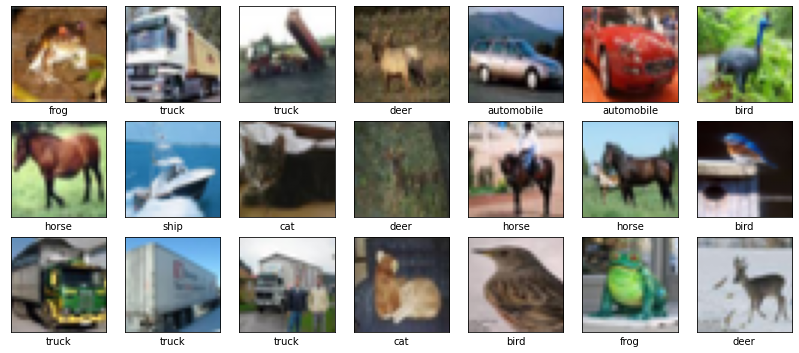

In [18]:
# Několik prvků datasetu
visualize_data(x_train, y_train, class_names)

In [19]:
# Příprava augmentace dat, opatření proti přetrénování

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [20]:
# Transformace NumPy array na tf.data.Dataset objekt, optimalizace výkonu 

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

train_dataset = train_dataset.prefetch(buffer_size = 128)
val_dataset = val_dataset.prefetch(buffer_size = 128)

In [21]:

# definice modelu, základ převzat z oficiální dokumentace kerasu:
# https://keras.io/examples/vision/image_classification_from_scratch/

def get_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_activation = x

    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

        residual = layers.Conv2D(size, 1, strides = 2, padding = "same")(
            previous_activation
        )
        x = layers.add([x, residual])
        previous_activation = x

    x = layers.SeparableConv2D(512, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation = activation)(x)

    return keras.Model(inputs, outputs)


In [22]:
# Konstrukce, kompilace a trénování modelu
epochs = 100

model = get_model(input_shape = (32, 32, 3), num_classes = num_classes)

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

model.fit(
    train_dataset, epochs = epochs, validation_data = val_dataset
)

# Přesnost a ztrátová funkce učebního procesu
loss, acc = model.evaluate(val_dataset)
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

Epoch 1/100
782/782 [==============================] - 95s 121ms/step - loss: 0.2355 - accuracy: 0.4602 - val_loss: 0.2234 - val_accuracy: 0.5066
Epoch 2/100
782/782 [==============================] - 95s 121ms/step - loss: 0.1874 - accuracy: 0.5913 - val_loss: 0.2288 - val_accuracy: 0.5387
Epoch 3/100
782/782 [==============================] - 89s 113ms/step - loss: 0.1679 - accuracy: 0.6378 - val_loss: 0.1798 - val_accuracy: 0.6301
Epoch 4/100
782/782 [==============================] - 89s 114ms/step - loss: 0.1558 - accuracy: 0.6704 - val_loss: 0.1868 - val_accuracy: 0.6215
Epoch 5/100
782/782 [==============================] - 90s 115ms/step - loss: 0.1462 - accuracy: 0.6962 - val_loss: 0.2083 - val_accuracy: 0.5974
Epoch 6/100
782/782 [==============================] - 93s 119ms/step - loss: 0.1389 - accuracy: 0.7136 - val_loss: 0.1772 - val_accuracy: 0.6460
Epoch 7/100
782/782 [==============================] - 94s 121ms/step - loss: 0.1332 - accuracy: 0.7228 - val_loss: 0.1553 -

In [23]:
# Uložení modelu, výsledná přesnost 81%
# Hardware prostředky poskytl Michal Štefl
model.save('neuronka')

C:\Users\Misak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
INFO:tensorflow:Assets written to: neuronka\assets
